In [8]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Prepare Data

## Import data

In [6]:
df = pd.read_csv("data/df_clean.csv")

## Explore data

In [7]:
print("Dimensions of the dataframe")
print(df.shape)

print("Information of dataset")
print(df.info())

print("The first five rows")
print(df.head())

Dimensions of the dataframe
(8591, 18)
Information of dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8591 entries, 0 to 8590
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age_days                            8591 non-null   int64  
 1   sex                                 8591 non-null   object 
 2   region                              8591 non-null   object 
 3   area                                8591 non-null   object 
 4   child_lenhei_cm                     8591 non-null   float64
 5   child_weight_kg                     8591 non-null   float64
 6   child_ill_cough_two_weeks           8591 non-null   object 
 7   child_ill_fever_two_weeks           8591 non-null   object 
 8   child_had_diarrhoea_last_two_weeks  8591 non-null   object 
 9   health_insurance                    8591 non-null   object 
 10  mother_educational_level            8591 non-n

stunting
Normal      0.826679
Stunting    0.173321
Name: proportion, dtype: float64


<Axes: xlabel='stunting'>

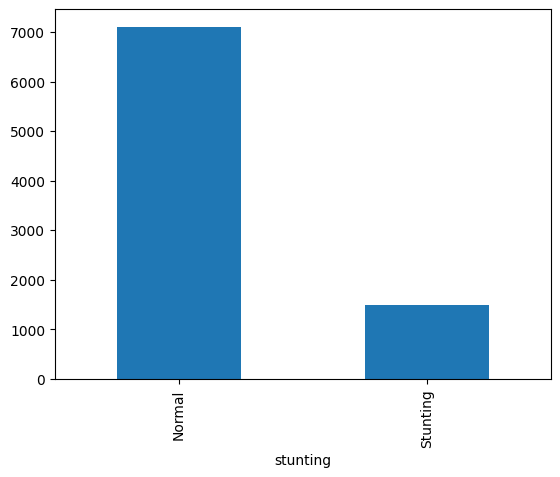

In [21]:
## Stunting
print(df["stunting"].value_counts(normalize=True))
df["stunting"].value_counts().plot(kind="bar")

wasting
Normal     0.929694
Wasting    0.070306
Name: proportion, dtype: float64


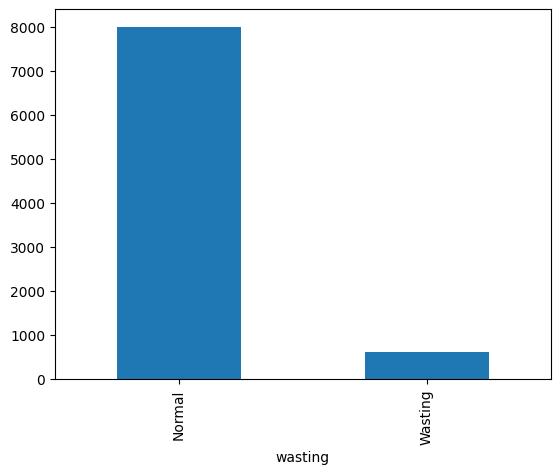

In [22]:
## Wasting
print(df["wasting"].value_counts(normalize=True))
df["wasting"].value_counts().plot(kind="bar");

underweight
Normal         0.87743
Underweight    0.12257
Name: proportion, dtype: float64


<Axes: xlabel='underweight'>

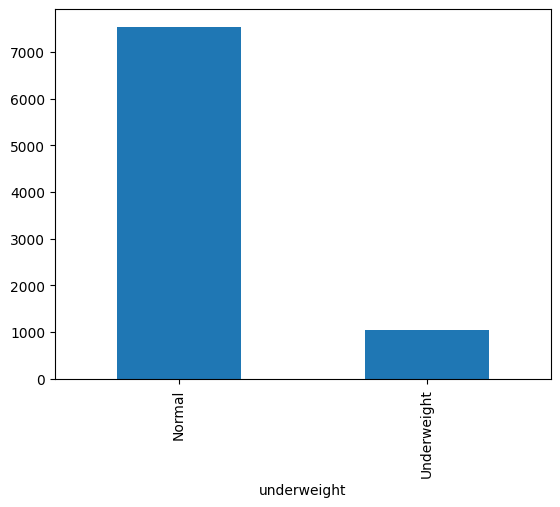

In [23]:
## Underweight
print(df["underweight"].value_counts(normalize=True))
df["underweight"].value_counts().plot(kind="bar")